In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

from statsmodels.tsa.stattools import acf, pacf
from pmdarima import auto_arima

import plotly
import cufflinks as cf
cf.go_offline()

In [810]:
#Joint plot function from LAB
def create_joint_plot(forecast, x='yhat', y='y', title=None): 
    print(title + ' R = {:+4.2f}'.format(forecast.loc[:,['y','yhat']].corr().iloc[0,1]))

    g = sns.jointplot(x='yhat', y='y', data=forecast, kind="reg", color="b")
    g.fig.set_figwidth(8)
    g.fig.set_figheight(8)
    

    ax = g.fig.axes[0]
    ax.set_xlabel('Predictions', fontsize=15)
    ax.set_ylabel('Observations', fontsize=15)
    ax.grid(ls=':')
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()];

    ax.grid(ls=':')

In [2]:
# reading the data
df = pd.read_csv('complete_mean_30.csv')

In [830]:
# formatting data for fb prophet
data = df[df.columns[:-1]]
data.Date = pd.to_datetime(data['Unnamed: 0'])
data.columns = ['ds','y','sp500','mic','goog','amz','volume','oil','covid','dif']
data_u = data.drop('dif',axis=1)

C:\Users\mkask\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



# Train test split

In [833]:
data_u.dropna(inplace=True)
df_train = data_u.loc[data["ds"]<"2020-04-30"]
df_test  = data_u.loc[data["ds"]>="2020-04-30"]

In [835]:
df_test.shape

(171, 9)

# Finding holidays

In [836]:
import holidays

holidays_df = pd.DataFrame([], columns = ['ds','holiday'])
ldates = []
lnames = []
for date, name in sorted(holidays.UnitedStates(years=np.arange(2017, 2020+1)).items()):
    ldates.append(date)
    lnames.append(name)
    
ldates = np.array(ldates)
lnames = np.array(lnames)
holidays_df.loc[:,'ds'] = ldates
holidays_df.loc[:,'holiday'] = lnames
holidays_df.holiday.unique()

holidays_df.loc[:,'holiday'] = holidays_df.loc[:,'holiday'].apply(lambda x : x.replace(' (Observed)',''))

# Univariate Forecasting

In [837]:
from fbprophet import Prophet

m = Prophet(holidays=holidays_df,
            interval_width=0.95,
            seasonality_mode='additive',
            yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False)
m.fit(df_train)
future = m.make_future_dataframe(periods=len(df_test), freq='1D')

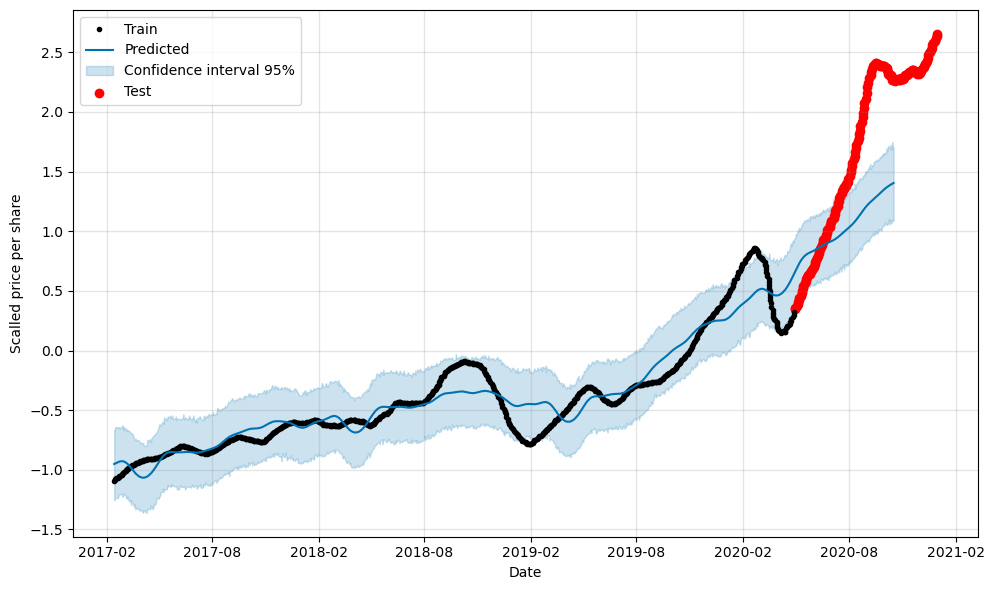

Train set R = +0.92
Test set R = +0.92


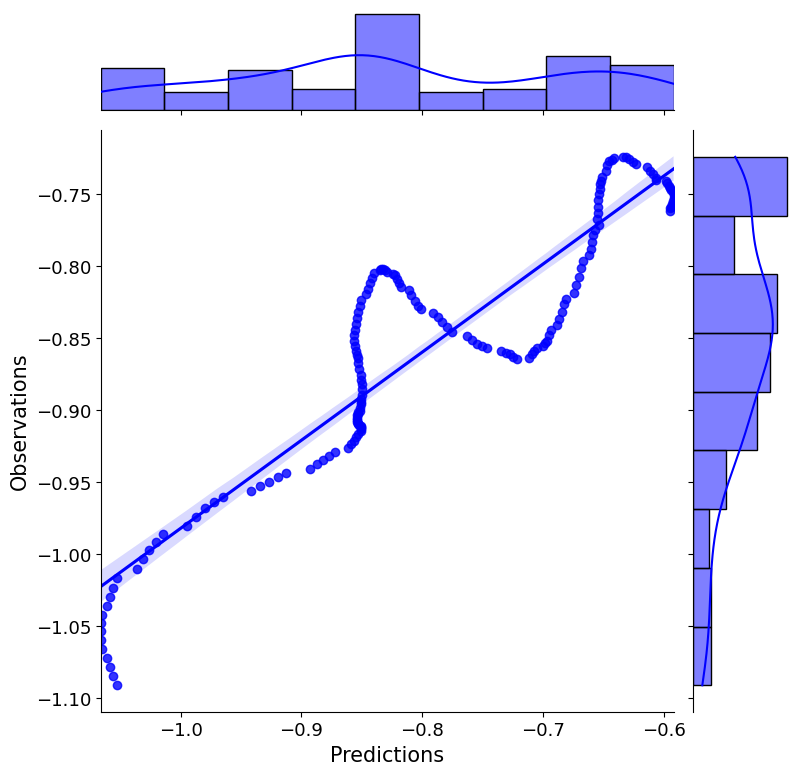

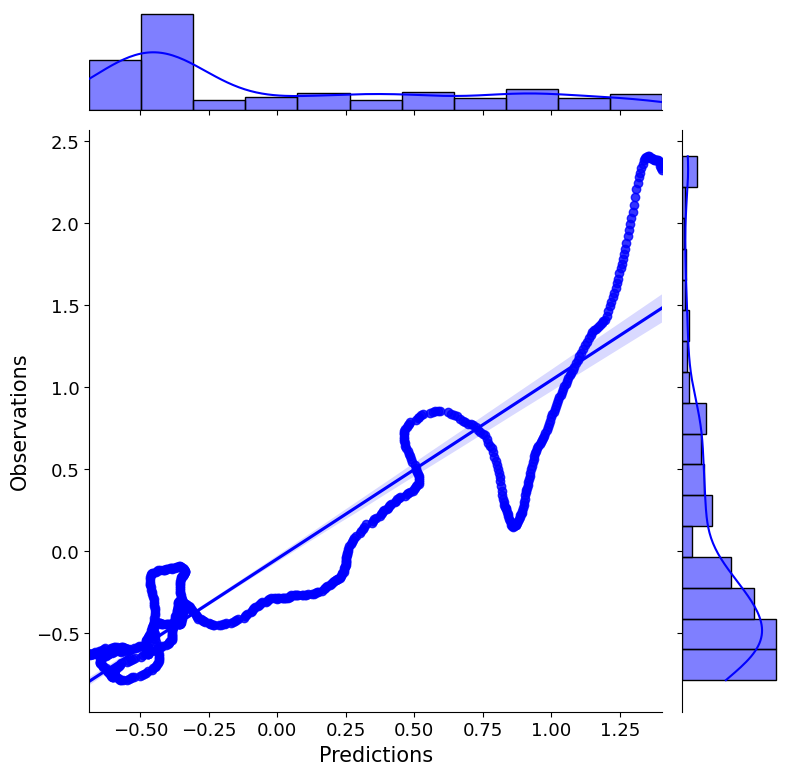

In [838]:
forecast = m.predict(future)
# plot forecast
m.plot(forecast)
plt.scatter(df_test.ds,df_test.y,color='r')
plt.legend(['Train','Predicted','Confidence interval 95%', 'Test'])
plt.xlabel('Date')
plt.ylabel('Scalled price per share')
plt.show()
forecast['y'] = data.y
create_joint_plot(forecast.loc[:'2020-04-30', :], title='Train set')
create_joint_plot(forecast.loc['2020-04-30':, :], title='Test set')

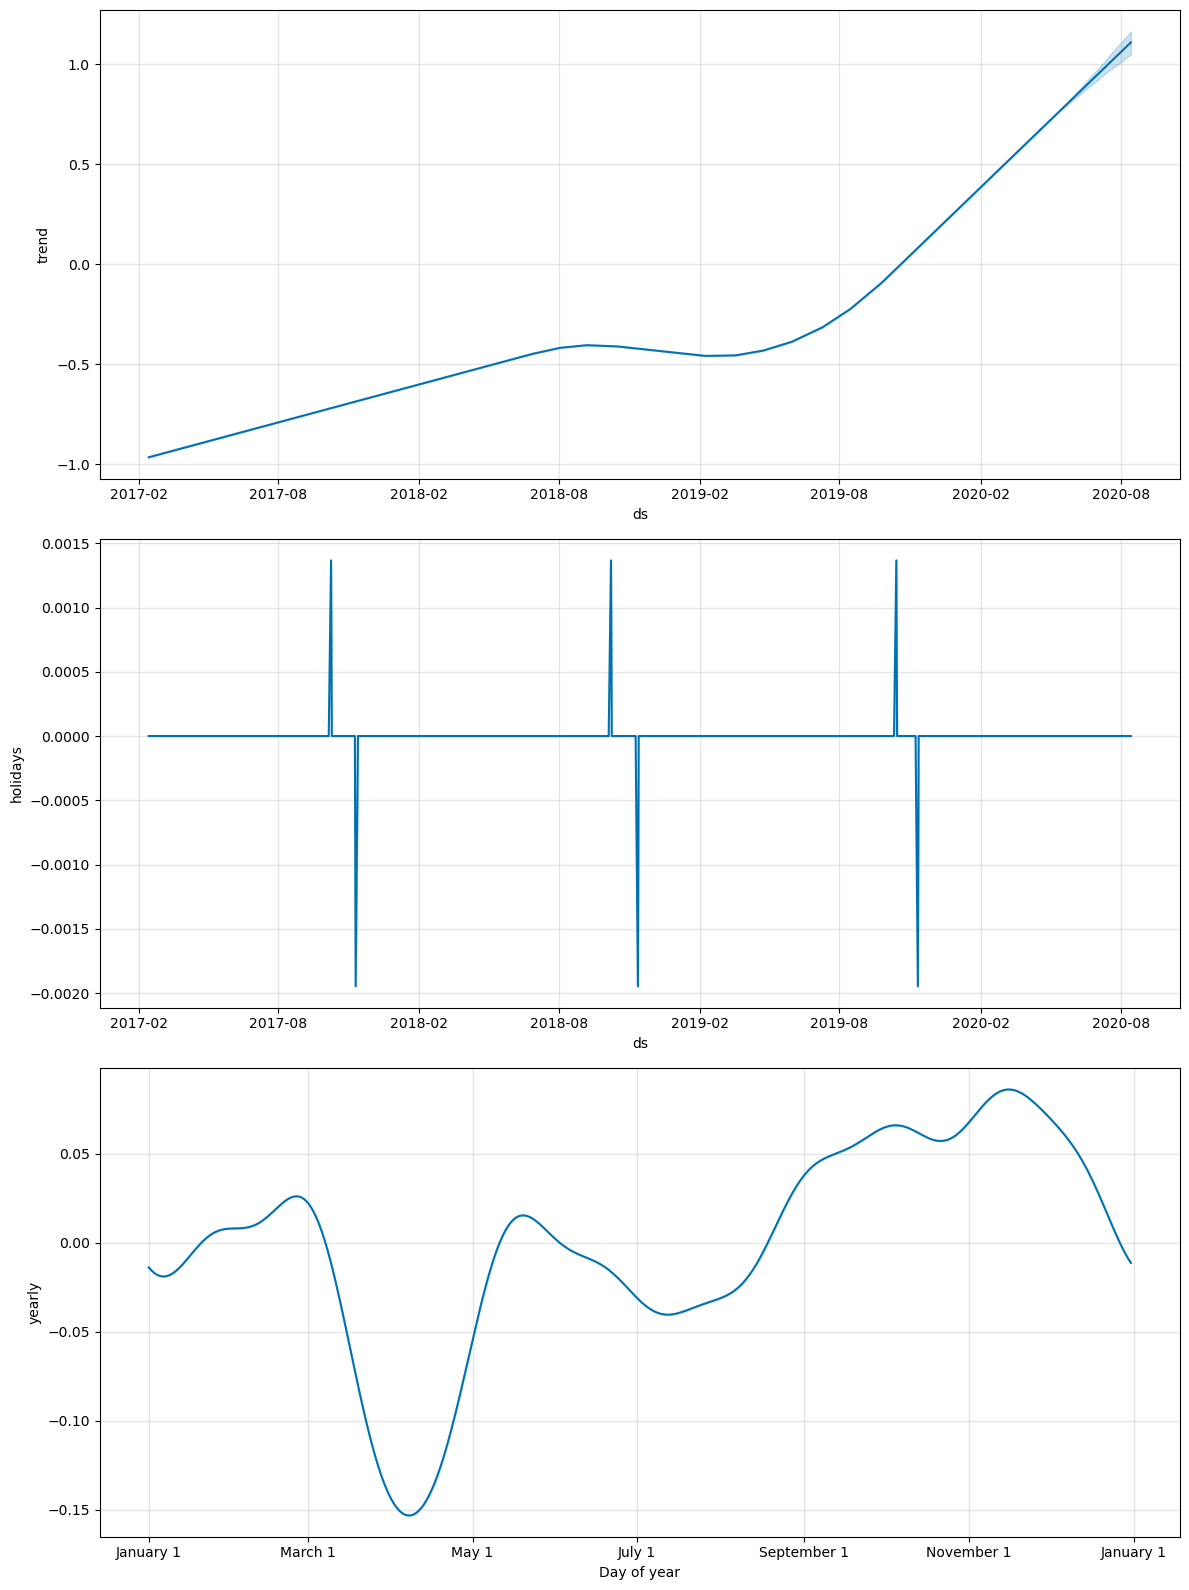

In [814]:
f = m.plot_components(forecast, figsize=(12, 16))

# R2 SCORE

In [817]:
f = forecast.dropna()
print(r2_score(f['yhat'],f['y']))

0.8495825152049182


# Multiple regressors

In [459]:
#function from lab
def is_pandemic_affected(ds):
    date = pd.to_datetime(ds)
    return date.year == 2020

In [633]:
data1 = data.copy()

data1['pandemic_affected'] = data1['ds'].apply(is_pandemic_affected)
data1['not_pandemic_affected'] = ~data1['ds'].apply(is_pandemic_affected)

df_train = data1.loc[data["ds"]<"2020-04-30"]
df_test  = data1.loc[data["ds"]>="2020-04-30"]

# To plot different models just comment out different regressors

In [828]:
m1 = Prophet(holidays=holidays_df,
             interval_width=0.95,
            seasonality_mode='additive',
            yearly_seasonality=False,
            weekly_seasonality=False,
            daily_seasonality=False)

m1.add_regressor('sp500')
m1.add_regressor('mic')
m1.add_regressor('goog')
#m1.add_regressor('amz') -> removed / not used
m1.add_regressor('volume')
m1.add_regressor('oil')
#m1.add_regressor('covid') - > removed / not used
m1.add_regressor('dif')

m1.add_seasonality(name='pandemic_affected', period=365, fourier_order=2, mode='additive', condition_name='pandemic_affected')
m1.add_seasonality(name='not_pandemic_affected', period=365, fourier_order=2, mode='additive', condition_name='not_pandemic_affected')

m1.fit(df_train)

future = m.make_future_dataframe(periods=len(df_test), freq='1D')
future['sp500'] = data['sp500']
future['mic'] = data['mic']
future['goog'] = data['goog']
future['amz'] = data['amz']
future['volume'] = data['volume']
future['covid'] = data['covid']
future['oil'] = data['oil']
future['dif'] = data['dif']
future['pandemic_affected'] = future['ds'].apply(is_pandemic_affected)
future['not_pandemic_affected'] = ~future['ds'].apply(is_pandemic_affected)
future.dropna(inplace=True)

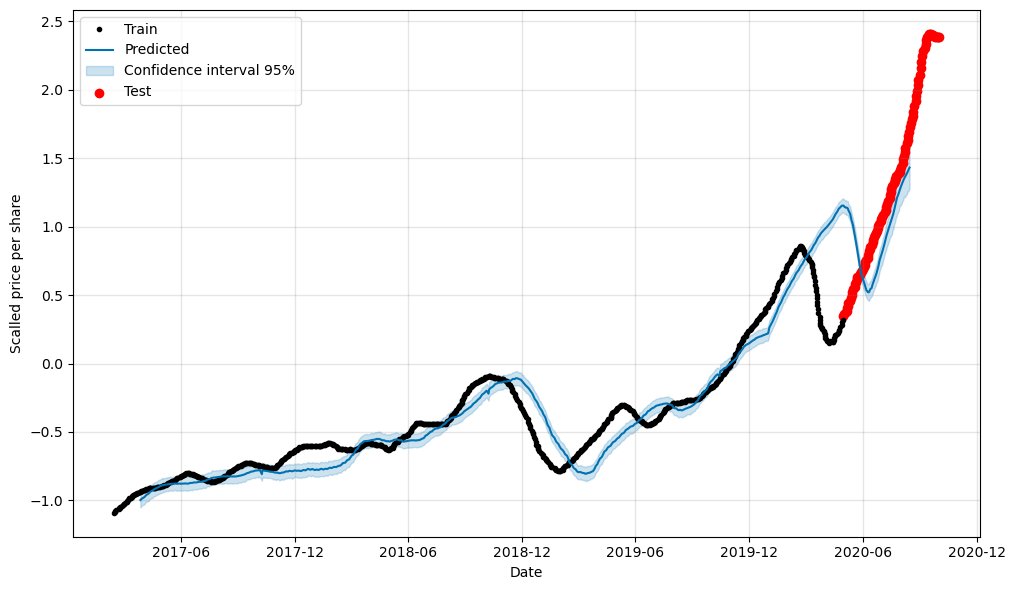

Train set R = +0.89
Test set R = +0.87


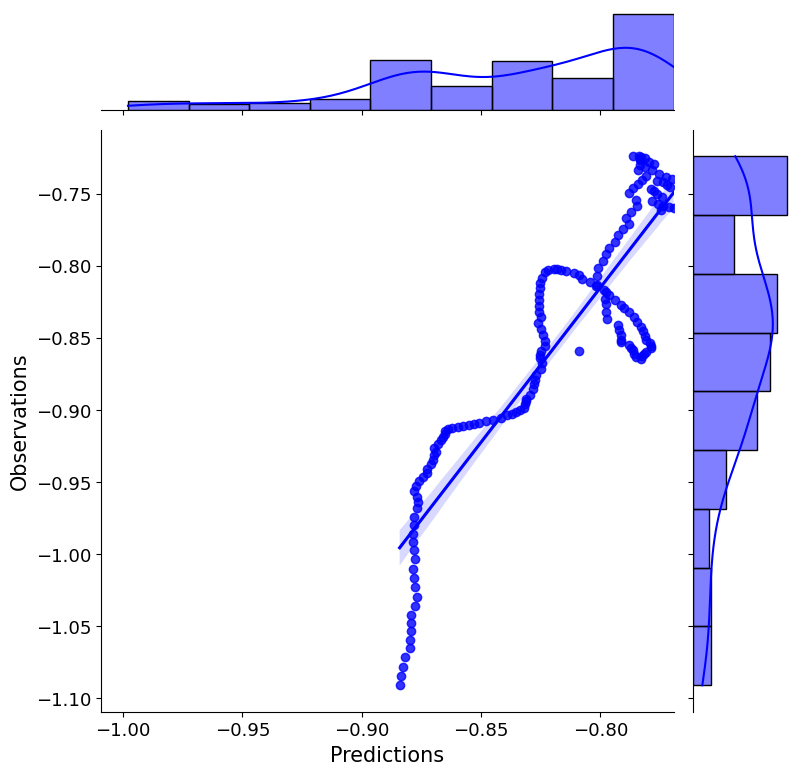

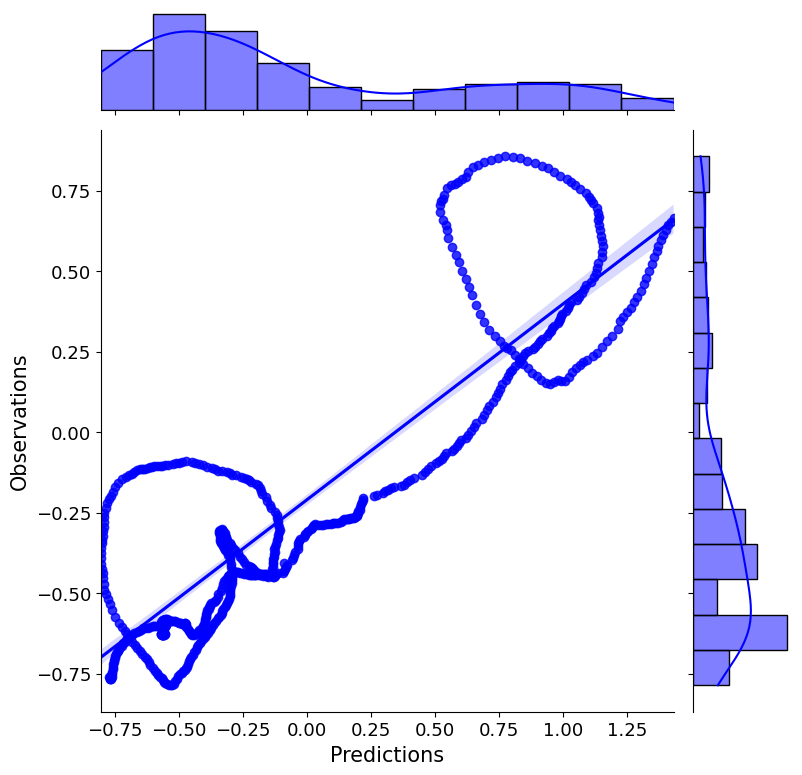

In [829]:
forecast = m1.predict(future)
# plot forecast
m1.plot(forecast)
plt.scatter(df_test.ds,df_test.y,color='r')
plt.legend(['Train','Predicted','Confidence interval 95%', 'Test'])
plt.xlabel('Date')
plt.ylabel('Scalled price per share')
plt.show()
forecast['y'] = data.y
create_joint_plot(forecast.loc[:'2020-04-30', :], title='Train set')
create_joint_plot(forecast.loc['2020-04-30':, :], title='Test set')

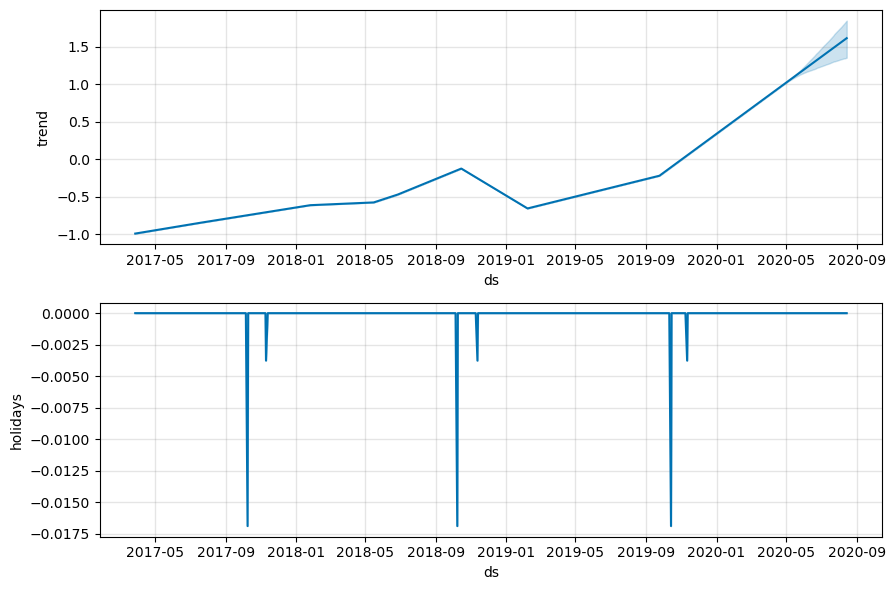

In [826]:
fig = m.plot_components(forecast)

# R2 SCORE

In [827]:
f = forecast.dropna()
print(r2_score(f['yhat'],f['y']))

0.4875318147340991
